In [1]:
import os
import sys
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("paper")

In [2]:
pd.__version__

'0.24.2'

# Import Simulated Data with MRCC Values

In [36]:
%%bash
mkdir -p ../data
curl -L https://osf.io/4y7xd/download -o ../data/simreads-compare.dnainput.mrcc.csv.gz
ls ../data

simreads-compare.dnainput.csv.gz
simreads-compare.dnainput.mrcc.csv.gz
simreads-compare.dnainput.processed.csv.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1095      0 --:--:-- --:--:-- --:--:--  1092
100 10.4M  100 10.4M    0     0  3954k      0  0:00:02  0:00:02 --:--:-- 9974k


In [37]:
sDF = pd.read_csv("../data/simreads-compare.dnainput.mrcc.csv.gz")
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh
0,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1,0.190577,0.320984,0.319303,1.0,4993153,4967010,1594331,dna-21,4980081.5,0.047995,0.052436,0.052913
1,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,100,0.192184,0.322739,0.322739,1.0,49616,49718,16013,dna-21,4980081.5,0.047995,0.051623,0.053241
2,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1000,0.197087,0.332343,0.326269,1.0,5143,5049,1678,dna-21,4980081.5,0.047995,0.049115,0.053137
3,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,2000,0.201250,0.338455,0.331748,1.0,2523,2473,837,dna-21,4980081.5,0.047995,0.047607,0.053033
4,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1,0.107025,0.193865,0.192850,1.0,4993150,4967004,962929,dna-31,4980077.0,0.047995,0.051284,0.051808


In [99]:
sDF.shape

(155143, 20)

## Assess p-distance estimation

In [40]:
# first, get point estimate from pLow and pHigh
sDF["mc_pdist"] = (sDF["mc_pLow"] + sDF["mc_pHigh"])/2
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist
0,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1,0.190577,0.320984,0.319303,1.0,4993153,4967010,1594331,dna-21,4980081.5,0.047995,0.052436,0.052913,0.052675
1,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,100,0.192184,0.322739,0.322739,1.0,49616,49718,16013,dna-21,4980081.5,0.047995,0.051623,0.053241,0.052432
2,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1000,0.197087,0.332343,0.326269,1.0,5143,5049,1678,dna-21,4980081.5,0.047995,0.049115,0.053137,0.051126
3,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,2000,0.201250,0.338455,0.331748,1.0,2523,2473,837,dna-21,4980081.5,0.047995,0.047607,0.053033,0.050320
4,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1,0.107025,0.193865,0.192850,1.0,4993150,4967004,962929,dna-31,4980077.0,0.047995,0.051284,0.051808,0.051546


In [41]:
# let's make a column for the difference between the point estimate and the mc_pdist
sDF["pdist_diff"] = sDF["true p-distance"] - sDF["mc_pdist"]
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist,pdist_diff
0,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1,0.190577,0.320984,0.319303,1.0,4993153,4967010,1594331,dna-21,4980081.5,0.047995,0.052436,0.052913,0.052675,-0.004679
1,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,100,0.192184,0.322739,0.322739,1.0,49616,49718,16013,dna-21,4980081.5,0.047995,0.051623,0.053241,0.052432,-0.004437
2,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1000,0.197087,0.332343,0.326269,1.0,5143,5049,1678,dna-21,4980081.5,0.047995,0.049115,0.053137,0.051126,-0.003131
3,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,2000,0.201250,0.338455,0.331748,1.0,2523,2473,837,dna-21,4980081.5,0.047995,0.047607,0.053033,0.050320,-0.002325
4,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1,0.107025,0.193865,0.192850,1.0,4993150,4967004,962929,dna-31,4980077.0,0.047995,0.051284,0.051808,0.051546,-0.003551


In [55]:
# this Dataframe includes 4 scaled values, 3 ksize values == 12 combinations per simulated read pair comparison
sDF[sDF["comparison_name"] == "data-d0.05-f1-nogam-seed36"] #example

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist,pdist_diff
0,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1,0.190577,0.320984,0.319303,1.0,4993153,4967010,1594331,dna-21,4980081.5,0.047995,0.052436,0.052913,0.052675,-0.004679
1,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,100,0.192184,0.322739,0.322739,1.0,49616,49718,16013,dna-21,4980081.5,0.047995,0.051623,0.053241,0.052432,-0.004437
2,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1000,0.197087,0.332343,0.326269,1.0,5143,5049,1678,dna-21,4980081.5,0.047995,0.049115,0.053137,0.051126,-0.003131
3,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,2000,0.201250,0.338455,0.331748,1.0,2523,2473,837,dna-21,4980081.5,0.047995,0.047607,0.053033,0.050320,-0.002325
4,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1,0.107025,0.193865,0.192850,1.0,4993150,4967004,962929,dna-31,4980077.0,0.047995,0.051284,0.051808,0.051546,-0.003551
5,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,100,0.106976,0.193632,0.192922,1.0,49932,49749,9633,dna-31,4980077.0,0.047995,0.050779,0.052394,0.051586,-0.003591
6,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1000,0.104772,0.192540,0.186888,1.0,5110,4960,955,dna-31,4980077.0,0.047995,0.049772,0.053775,0.051774,-0.003778
7,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,2000,0.105969,0.193944,0.189373,1.0,2503,2444,474,dna-31,4980077.0,0.047995,0.048855,0.054275,0.051565,-0.003569
8,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,51,1,0.036558,0.070724,0.070353,1.0,4993130,4966984,351283,dna-51,4980057.0,0.047995,0.050286,0.050943,0.050614,-0.002619
9,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,51,100,0.036894,0.071625,0.070704,1.0,49997,49354,3535,dna-51,4980057.0,0.047995,0.049471,0.051296,0.050383,-0.002388


# Point estimate comparisons

In [98]:
# there are some comparisons with no k-mers/hashes in common -- let's eliminate these
sDF = sDF[sDF["num_common"] != 0]
sDF.shape

(155143, 20)

In [100]:
# let's just work with scaled=1 to start:
s1DF = sDF[sDF["scaled"] == 1]

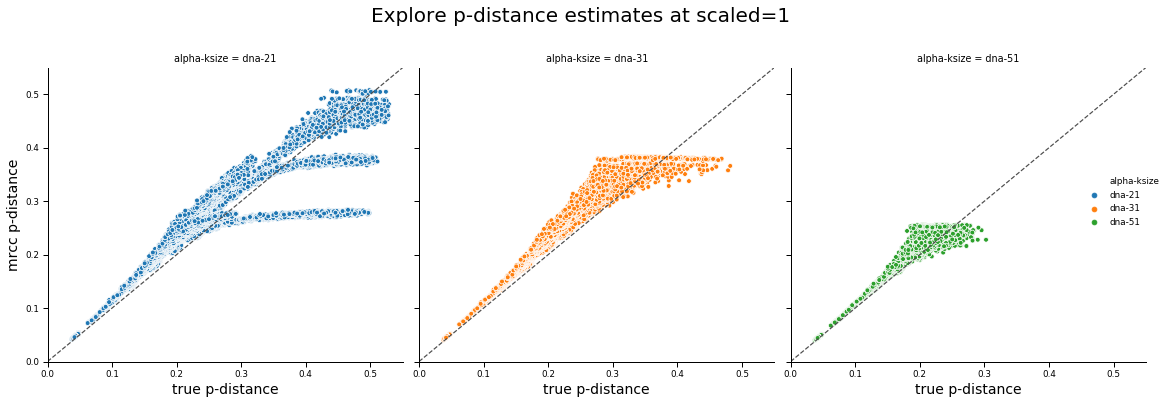

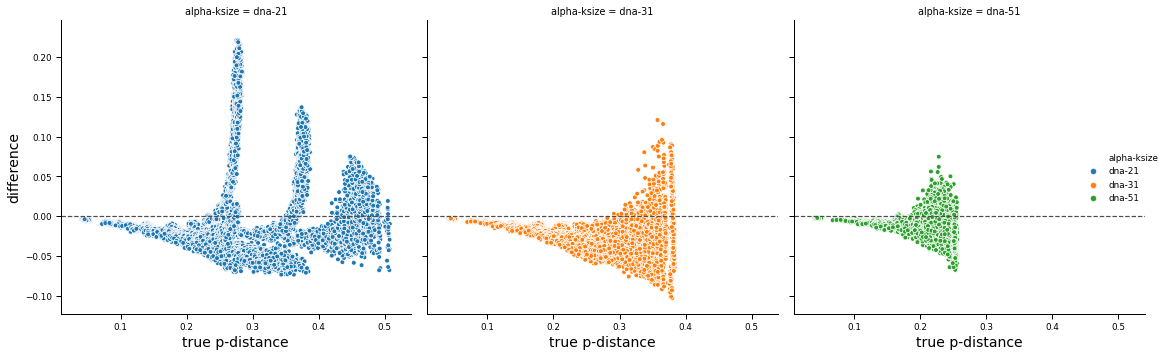

In [147]:
data_to_plot = s1DF # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()


In [61]:
sDF_3 = s1DF[s1DF["num_common"] >= 3]

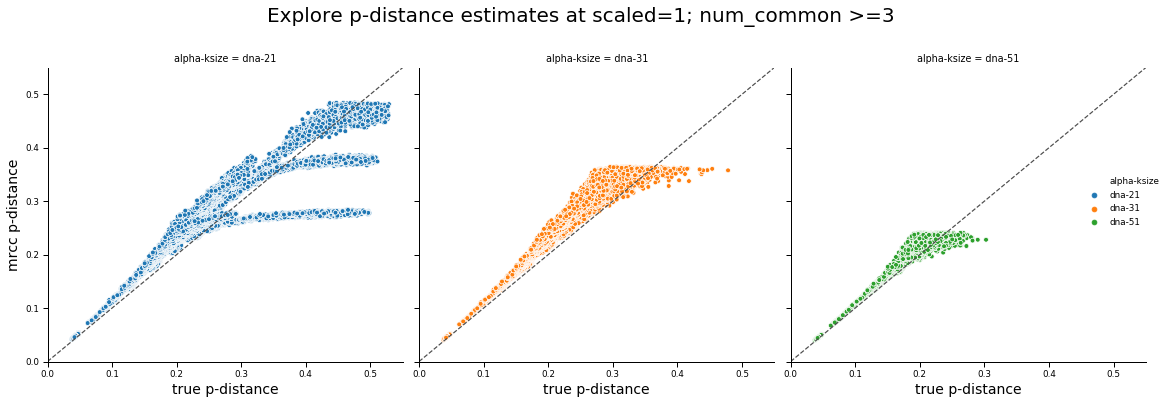

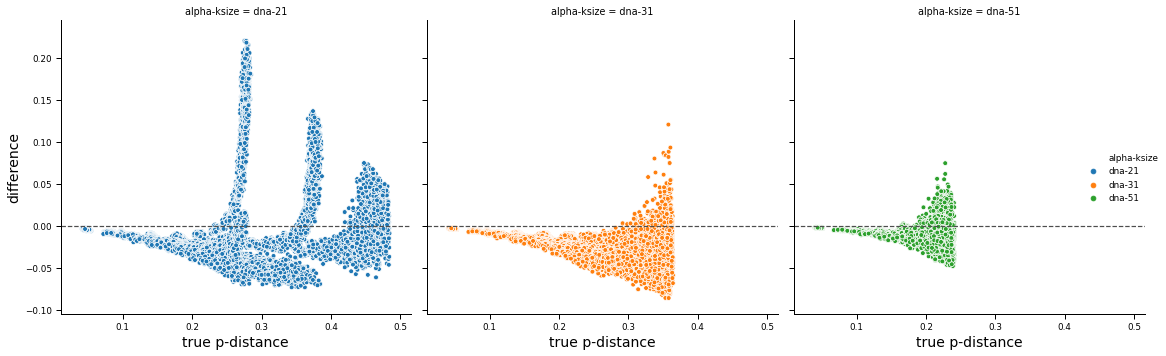

In [120]:
data_to_plot = sDF_3 # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; num_common >=3", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

In [77]:
sDF_minC = s1DF[s1DF["max_containment"] >= 0.0001]

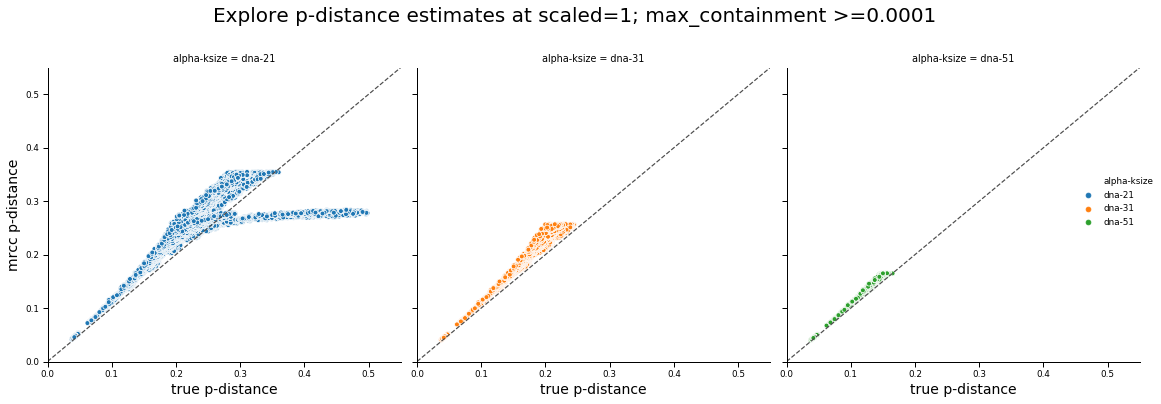

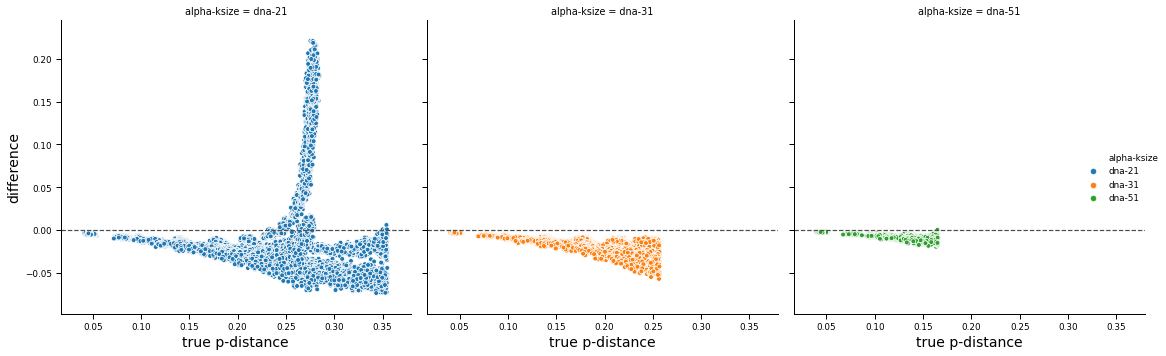

In [121]:
data_to_plot = sDF_minC # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; max_containment >=0.0001", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

In [122]:
sDF_minC2 = s1DF[s1DF["max_containment"] >= 0.0002]

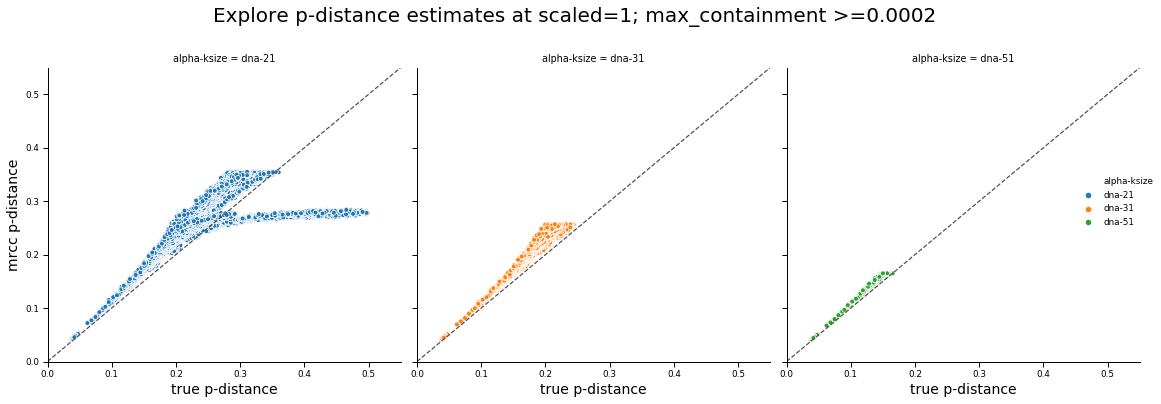

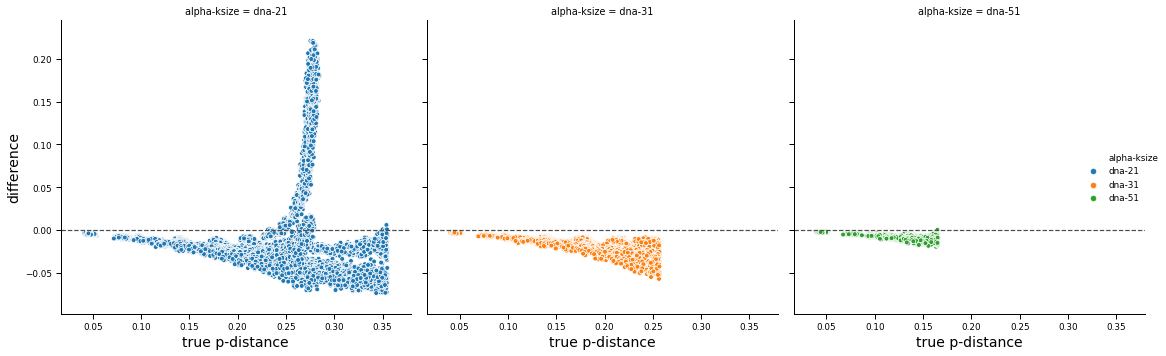

In [123]:
data_to_plot = sDF_minC # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; max_containment >=0.0002", x=0.5, y=1.10, size=20)


d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

# CI Plotting

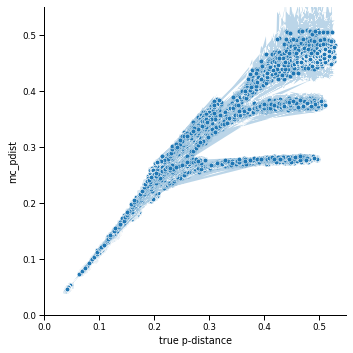

In [145]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

#xlim =g.get_xlim()
#ylim = g.get_ylim()
#g.plot(xlim, ylim, ls="--", c=".3")
#g.set_xlabel("true p-distance", size=14)
#g.set_ylabel("mrcc p-distance", size=14)
#g.add_legend()
#g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)


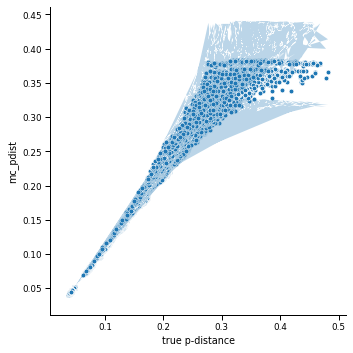

In [150]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-31"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
#g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

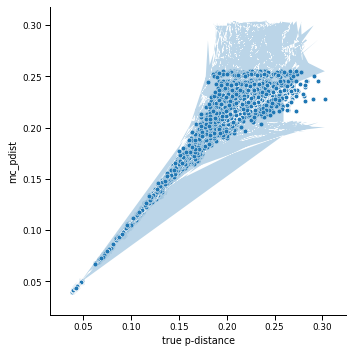

In [151]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-51"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
#g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

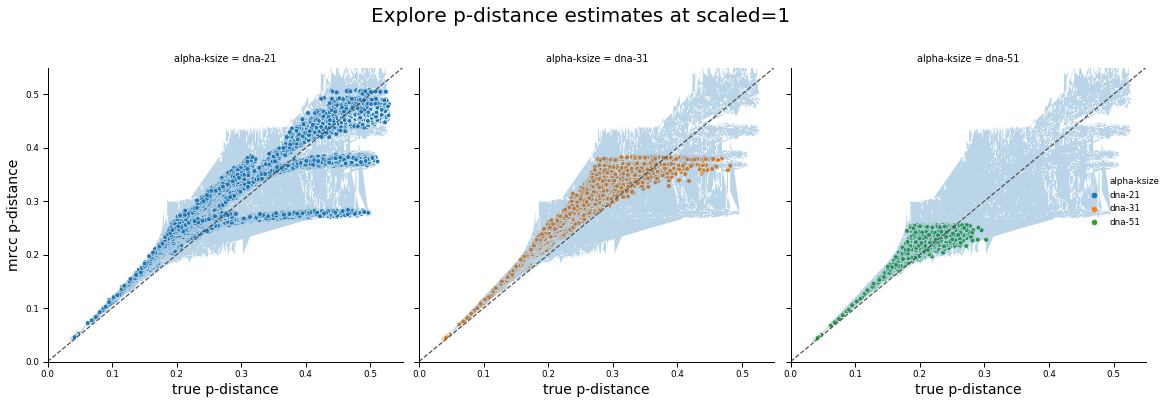

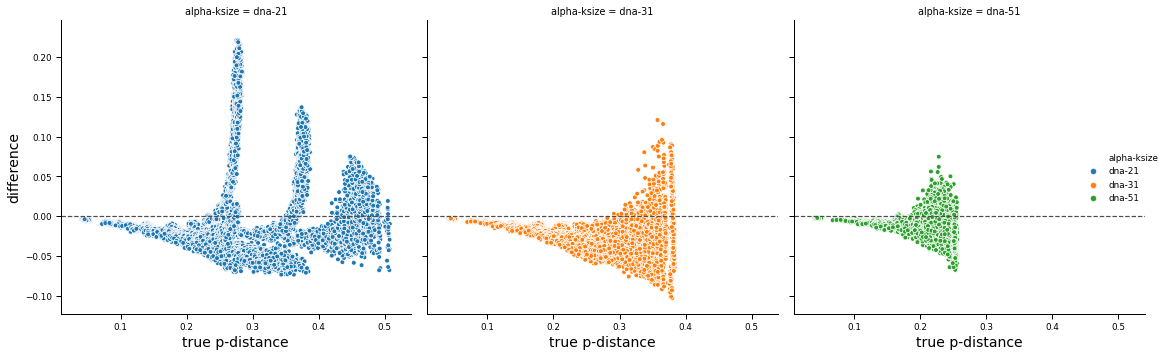

In [148]:
data_to_plot = s1DF # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ## this is ALL confidence values, not done by alpha-ksize :(())
    ax.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()
